In [1]:
from anomaly_dct import AnomalyDct
import datetime
import cv2
import os
import time
import numpy as np
import threading
import datetime
import matplotlib.pyplot as plt
import imageio

# DCT

In [4]:
ad = AnomalyDct()
piAddress = '0.0.0.0'

def detect(DEBUG=True):
    #     global vs, outputFrame, lock, isAbnormal, data, recoveryFlag
    global isAbnormal, data
    curr = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    
    ad.DEBUG = DEBUG
    if ad.DEBUG:

        ad.d_folder = 'tmp'
#         fname = '20210419_idle3.avi'
        fname = '20210414_qrcode.mp4'
        ad.fname = fname
        
#         ad.vidcap = cv2.VideoCapture(f'/home/jayhsu/AA/dct2.0_demo/video/{fname}')
        ad.vidcap = cv2.VideoCapture(f'video/{fname}')

        output_name = ad.fname.split('/')[-1]
        ad.writer_inf = imageio.get_writer(os.path.join(ad.d_folder, fname + '.mp4'), format='mp4', mode='I', fps=25)

#         ad.d_folder = 'tmp\\'
#         fname = 'bsod_0329_193.mp4'
#         ad.fname = fname
       
#         ad.vidcap = cv2.VideoCapture(f'C:\\Users\\echo_lee\\Desktop\\fail\\{fname}')
#         output_name = ad.fname.split('\\')[-1]

    else:
        ad.vidcap = cv2.VideoCapture(0)
        ad.fname = ad.video_path + curr
    if not os.path.exists(ad.d_folder):
        os.makedirs(ad.d_folder)

#     ad.mog = cv2.bgsegm.createBackgroundSubtractorGMG() 
    ad.mog = cv2.createBackgroundSubtractorMOG2()
    while ad.success:
        ad.success, ad.image = ad.vidcap.read()
        if ad.success:
            start = time.time()
            ad.fid += 1
            ad.feature_dict['fid'] = ad.fid
            ad.feature_dict['obj_class'] = ""
                        
            # -- save complete video --
            ad.save_complete_video()
            # -- Search white positioning block -- 
            ad.is_test_item = ad.get_Wblack(ad.image, ad.search_wblock)
            ad.wblock_accum_score = max(ad.wblock_accum_score,0) if ad.is_test_item else min(ad.wblock_accum_score,0)
            ad.wblock_accum_score = ad.wblock_accum_score+(1 if ad.is_test_item else -1)
            if ad.wblock_accum_score>40:
                ad.search_wblock=False
            elif ad.wblock_accum_score<-40:
                ad.search_wblock=True

            # -- detect pass windows --
            if ad.is_test_item:
                ad.is_passed = ad.get_pass_window(ad.image, ad.passed_x_lower, ad.passed_x_upper, ad.passed_y_lower, ad.passed_y_upper)
                ad.feature_dict['is_passed'] = ad.is_passed
                if ad.is_passed:
                    ad.detect_pass()
                    # -- stop detect --
                    if ad.is_pass:
                        threading.Thread(target=ad.save_test_video, args=(ad.d_folder, ad.all_list, ad.fname, ad.fps)).start()
                        print('pass')
                        break

            # -- Baseline(test_spec) --
            ad.fgmask = ad.mog.apply(ad.image)
            ad.fgmask = np.clip(ad.fgmask, 0, 1)
#             cnts, _ = cv2.findContours(ad.fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#             for c in cnts:
#                 c_area = cv2.contourArea(c)
#                 (x, y, w, h) = cv2.boundingRect(c)
#                 cv2.rectangle(ad.image, (x, y), (x+w, y+h), (0, 0, 255), 2)
            if (ad.baseline_pass == False):
                ad.create_baseline()
            # -- Detect --
            else:
                ad.get_vbb_score()
                ad.anomaly_detect()
            # -- put_text & draw --
            ad.draw_picture(start)
#             # -- keep inference video --
            if ad.DEBUG:
                ad.keep_inference_video()

            if ad.is_anomaly:
                print('anomaly', ad.anomaly_type)
                isAbnormal = True
                # send the status to DCT server
                data = {'id':piAddress, 'state':ad.anomaly_type, 'afterStateChangeSec':0, 'videoName':{'0':ad.fname + ('_%d.mp4' % ad.vindex)}}
                print(data)
#                 postData2DCT(data)
                threading.Thread(target=ad.save_test_video, args=(ad.d_folder, ad.all_list, ad.fname, ad.fps)).start()
                threading.Thread(target=ad.save_test_video, args=(ad.d_folder, ad.image_list, ad.fname, ad.fps)).start() 
                break
    # -- save last video --
    threading.Thread(target=ad.save_test_video, args=(ad.d_folder, ad.all_list, ad.fname, ad.fps)).start()
    ad.writer_inf.close()
    print('fps mean:', round(np.mean(ad.fps_list)))    

In [5]:
if __name__ == '__main__':
    detect()

15 baseline_pass
qrcode 0.7088072896003723
anomaly BSOD
{'id': '0.0.0.0', 'state': 'BSOD', 'afterStateChangeSec': 0, 'videoName': {'0': '20210414_qrcode.mp4_0.mp4'}}
fps mean: 71.0


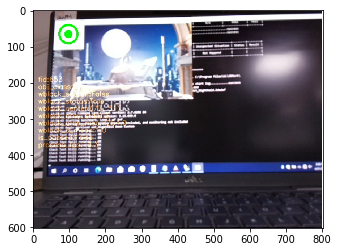

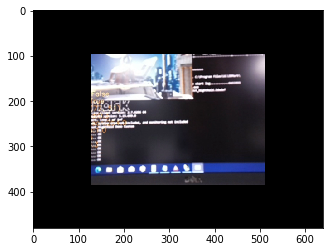

In [23]:
image_uhd = cv2.imread('pic.png')
plt.imshow(cv2.cvtColor(image_uhd, cv2.COLOR_BGR2RGB))
plt.show()
resized = cv2.resize(image_uhd, (640, 480), interpolation = cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))


image_mask_2 = cv2.bitwise_and(resized, resized, mask=image_mask)
plt.imshow(cv2.cvtColor(image_mask_2, cv2.COLOR_BGR2RGB))

In [7]:
(ad.height2-ad.height1)*(ad.width2-ad.width1)*(2/3)

73728.0

101043


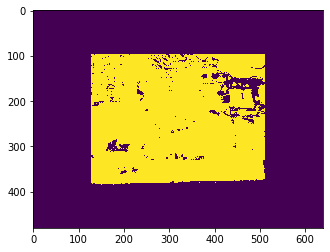

In [16]:
image_mask_2 = cv2.bitwise_and(ad.fgmask, ad.fgmask, mask=image_mask)
# plt.imshow(cv2.cvtColor(image_mask_2, cv2.COLOR_BGR2RGB))
plt.imshow(image_mask_2)
fg_pixels = np.count_nonzero(image_mask_2)
print(fg_pixels)

189124


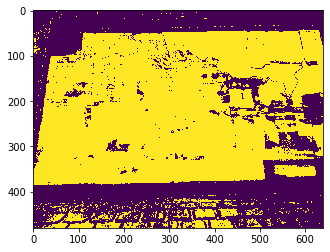

In [15]:
plt.imshow(ad.fgmask)
# cv2.cvtColor(ad.fgmask, cv2.COLOR_BGR2RGB)
fg_pixels = np.count_nonzero(ad.fgmask)
print(fg_pixels)

96 384 128 512
111265
0.3621907552083333
74176
74176


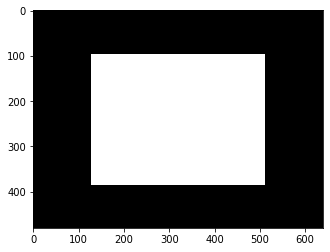

In [18]:
height1 = int(ad.height*(1/5))
height2 = int(ad.height*(4/5))
width1 = int(ad.width*(1/5))
width2 = int(ad.width*(4/5))
print(height1, height2, width1, width2)
mask_black = np.zeros((480,640), dtype="uint8")
cv2.rectangle(mask_black, (width1, height1), (width2, height2), 255, -1)

mask_white = np.zeros((480,640), dtype="uint8")
cv2.rectangle(mask_white, (0, 0), (ad.width, ad.height), 255, -1)
image_mask = cv2.bitwise_and(mask_white, mask_white, mask=mask_black)
plt.imshow(cv2.cvtColor(image_mask, cv2.COLOR_BGR2RGB))

fg_pixels = np.count_nonzero(image_mask)
fg_ratio = fg_pixels/(ad.width*ad.height)
spec_black = fg_pixels*2//3
spec_blue = fg_pixels*2//3

print(fg_pixels)
print(fg_ratio)
print(spec_black)
print(spec_blue)
# contour, _ = cv2.findContours(image_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
# if len(contour)>0:
#     contour = sorted(contour, key=lambda c: cv2.contourArea(c), reverse=True)
#     fg_contour = contour[0]
#     fgmask = cv2.drawContours(np.zeros_like(image_mask), [fg_contour], -1, 255, -1)
# image_mask_2 = cv2.bitwise_and(image_c, image_c, mask=fgmask)
# plt.imshow(cv2.cvtColor(image_mask_2, cv2.COLOR_BGR2RGB))

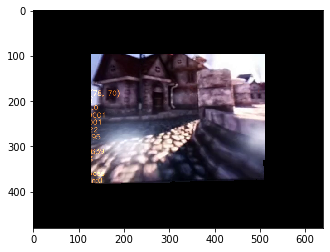

In [58]:
image_mask_2 = cv2.bitwise_and(image_c, image_c, mask=image_mask)
plt.imshow(cv2.cvtColor(image_mask_2, cv2.COLOR_BGR2RGB))

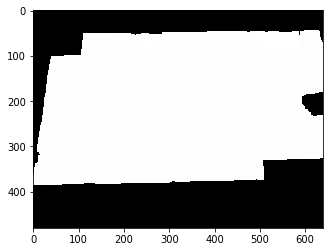

In [49]:
plt.imshow(cv2.cvtColor(ad.FG_MASK, cv2.COLOR_BGR2RGB))

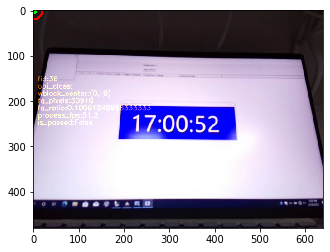

In [4]:
plt.imshow(cv2.cvtColor(ad.image_list[35], cv2.COLOR_BGR2RGB))

# PMU

In [12]:
ad = AnomalyDct()
piAddress = '0.0.0.0'

fr_list = []

def detect(DEBUG=True):
    #     global vs, outputFrame, lock, isAbnormal, data, recoveryFlag
    global isAbnormal, data
    curr = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    
    ad.DEBUG = DEBUG
    if ad.DEBUG:

        ad.d_folder = 'tmp'
#         fname = '20210419_idle3.avi'
        fname = 'PMU_CB_20210419.mp4'
        ad.fname = fname
       
        ad.vidcap = cv2.VideoCapture(f'video/{fname}')
        output_name = ad.fname.split('/')[-1]
                
#         ad.d_folder = 'tmp\\'
#         fname = 'bsod_0329_193.mp4'
#         ad.fname = fname
       
#         ad.vidcap = cv2.VideoCapture(f'C:\\Users\\echo_lee\\Desktop\\fail\\{fname}')
#         output_name = ad.fname.split('\\')[-1]
        ad.writer_inf = imageio.get_writer(os.path.join(ad.d_folder, fname + '.mp4'), format='mp4', mode='I', fps=25)

    else:
        ad.vidcap = cv2.VideoCapture(0)
        ad.fname = ad.video_path + curr
    if not os.path.exists(ad.d_folder):
        os.makedirs(ad.d_folder)
    
    spec_black = ad.width*ad.height//2
    spec_blue = ad.width*ad.height//2
    ad.feature_dict['spec_black'] = spec_black
    ad.spec_black = spec_black
    ad.feature_dict['spec_blue'] = spec_blue
    ad.spec_blue = spec_blue
    ad.spec_var = 10
    ad.count_sec = ad.fid + ad.fps*240
    print(spec_black, spec_blue, ad.count_sec)
#     ad.mog = cv2.bgsegm.createBackgroundSubtractorGMG()
    ad.mog = cv2.createBackgroundSubtractorMOG2()
    while ad.success:
        ad.success, ad.image = ad.vidcap.read()
        if ad.success:
            start = time.time()
            ad.fid += 1
            ad.feature_dict['fid'] = ad.fid
            ad.feature_dict['obj_class'] = ""
                
            # -- save complete video --
            ad.save_complete_video()
                        
            #check variation
            ad.fgmask = ad.mog.apply(ad.image)
            ad.var_pixel = np.count_nonzero(ad.fgmask)
            ad.img_move = cv2.bitwise_and(ad.image, ad.image, mask=ad.fgmask)
            ad.feature_dict['var_pixel'] = ad.var_pixel            
            ad.blue_score, ad.black_score = ad.get_img_feature_YUV_pmu(ad.image)
            ad.feature_dict['var_pixel'] = ad.var_pixel
            ad.feature_dict['blue_score'] = ad.blue_score
            ad.feature_dict['black_score'] = ad.black_score
            ad.is_hang = (ad.var_pixel < ad.spec_var)
            
            ad.detections = ad.yolo(ad.image_copy)
            ad.detect_pmuprocess()
            if ad.is_pmuprocess:
                ad.count_sec = ad.fid + (ad.fps*240)
            
            # -- anomaly detect --
            ad.anomaly_detect_pmu()
            
            # -- put_text & draw --
            ad.draw_picture(start)
#             # -- keep inference video --
            if ad.DEBUG:
                ad.keep_inference_video()

            if ad.is_anomaly:
                print('anomaly', ad.anomaly_type)
                isAbnormal = True
                # send the status to DCT server
                data = {'id':piAddress, 'state':ad.anomaly_type, 'afterStateChangeSec':0, 'videoName':{'0':ad.fname + ('_%d.mp4' % ad.vindex)}}
                print(data)
#                 postData2DCT(data)
                threading.Thread(target=ad.save_test_video, args=(ad.d_folder, ad.all_list, ad.fname, ad.fps)).start()
                threading.Thread(target=ad.save_test_video, args=(ad.d_folder, ad.image_list, ad.fname, ad.fps)).start() 
                break
    # -- save last video --
    threading.Thread(target=ad.save_test_video, args=(ad.d_folder, ad.all_list, ad.fname, ad.fps)).start()
    ad.writer_inf.close()
    print('fps mean:', round(np.mean(ad.fps_list)))    

In [1]:
if __name__ == '__main__':
    detect()

NameError: name 'detect' is not defined

In [9]:
import imageio
import os
all_frame_cnt_limit = 30
vindex = 0
folder = 'tmp'
fname = 'test'
fps = 5
writer_inf = imageio.get_writer(os.path.join(folder, fname + ('_%d.avi' % vindex)), format='avi', mode='I', fps=fps)
print(writer_inf.request.get_file())
for fid in range(1, 100):
    if fid % all_frame_cnt_limit == 0:
        vindex += 1
        print(vindex)
        writer_inf = imageio.get_writer(os.path.join(folder, fname + ('_%d.avi' % vindex)), format='avi', mode='I', fps=fps)
        print(writer_inf.request.get_file())
writer_inf.close()


<_io.BufferedWriter name='D:\\Git\\stream-video-browser\\tmp\\test_0.avi'>
1
<_io.BufferedWriter name='D:\\Git\\stream-video-browser\\tmp\\test_1.avi'>
2
<_io.BufferedWriter name='D:\\Git\\stream-video-browser\\tmp\\test_2.avi'>
3
<_io.BufferedWriter name='D:\\Git\\stream-video-browser\\tmp\\test_3.avi'>
